In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-kvtibzi9
All libraries are successfully installed!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np

In [0]:
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/npy_files/'

In [0]:
dataset_pre_processing_nneigh_pad = np.load(PATH_BASE + "dataset_pre_processing_nneigh_pad.npz")

In [6]:
immagini_db_nneigh_pad = dataset_pre_processing_nneigh_pad["immagini_db_nneigh_zeropadding"]
immagini_db_nneigh_pad.shape

(1446, 320, 320, 3)

In [7]:
reshaped_labels_nneigh_pad = dataset_pre_processing_nneigh_pad["reshaped_labels_zeropadding"]
reshaped_labels_nneigh_pad.shape

(1446, 320, 320)

In [0]:
normali_nneigh = dataset_pre_processing_nneigh_pad["normali_nneigh"]

In [0]:
from PIL import Image
import cv2

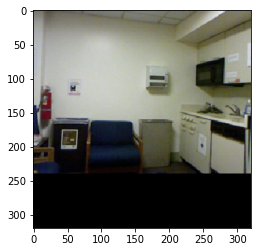

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
plt.imshow(immagini_db_nneigh_pad[0])

## Splitting test/ train

In [0]:
np.random.seed(1221)
indexes = range(0,reshaped_labels_nneigh_pad.shape[0])
permutated_indexes = np.random.permutation(indexes)
reshaped_labels_nneigh_pad = reshaped_labels_nneigh_pad[permutated_indexes, ...]
immagini_db_nneigh_pad = immagini_db_nneigh_pad[permutated_indexes, ...]

In [0]:
index_trainval = round(immagini_db_nneigh_pad.shape[0]*0.7)
x_trainval, y_trainval = immagini_db_nneigh_pad[:index_trainval, ...], reshaped_labels_nneigh_pad[:index_trainval, ...]
x_test, y_test = immagini_db_nneigh_pad[index_trainval:, ...], reshaped_labels_nneigh_pad[index_trainval:, ...]
normali_nneigh_test = normali_nneigh[index_trainval:, ]

In [0]:
index_train = round(x_trainval.shape[0]*0.8)
x_train, y_train = immagini_db_nneigh_pad[:index_train, ...], reshaped_labels_nneigh_pad[:index_train, ...]
x_val, y_val = immagini_db_nneigh_pad[index_train:, ...], reshaped_labels_nneigh_pad[index_train:, ...]

In [0]:
mask_indexes = []
for i in range(0, x_train.shape[0]):
  mask_indexes.extend([i] * 6)
mask_indexes = np.asarray(mask_indexes)

# Permutazioni dei channel RGB

In [0]:
def rgb_permutation(image):
  r,g,b = cv2.split(image)
  im = []
  im.append(cv2.merge((r,g,b)))
  im.append(cv2.merge((g,r,b)))
  im.append(cv2.merge((g,b,r)))
  im.append(cv2.merge((b,g,r)))
  im.append(cv2.merge((b,r,g)))
  im.append(cv2.merge((r,b,g)))
  return im

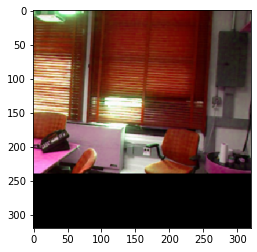

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
#plt.figure('es. predizione decodificata')
for im in rgb_permutation(x_train[0]):
  plt.imshow(im)

In [0]:
x_train_augmented = []
for n in range(0, x_train.shape[0]):
  x_train_augmented.extend(rgb_permutation(x_train[n, ]))

In [0]:
x_train_augmented = np.asarray(x_train_augmented)

# Filtraggi ottenuti con Albumentations

In [0]:
import albumentations as A

In [0]:
np.random.seed(1221)

In [0]:
def strong_augmentation(p):
  return A.OneOf([
        A.RandomBrightness(limit=(-0.5,0.5)),
        A.RandomGamma(gamma_limit=(20,200)),
        A.JpegCompression(quality_lower=4, quality_upper=100),
        A.HueSaturationValue(hue_shift_limit=172, sat_shift_limit=20, val_shift_limit=27),
        A.RandomContrast(limit=0.5)
      ],
      p = p
    )

In [0]:
augmentation = strong_augmentation(1)

In [0]:
x_train_augmented_albumented = []
for i in range(0, x_train_augmented.shape[0]):
  data = {'image': x_train_augmented[i, ]}
  augmented = augmentation(**data)
  x_train_augmented_albumented.append(augmented['image'])

In [0]:
x_train_augmented_albumented = np.asarray(x_train_augmented_albumented)

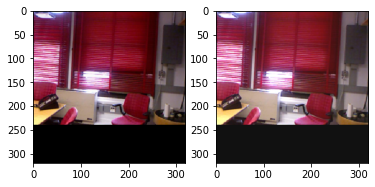

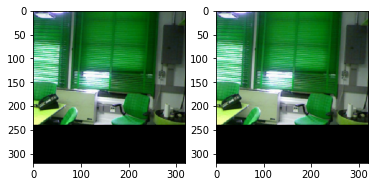

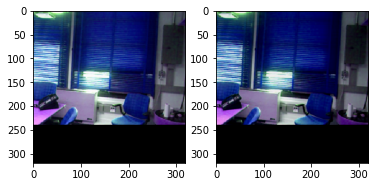

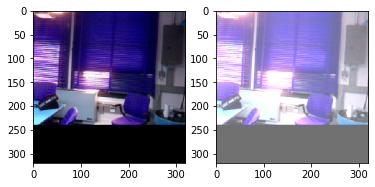

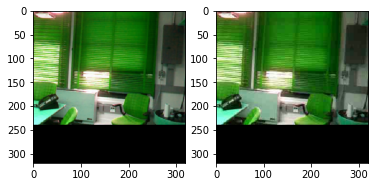

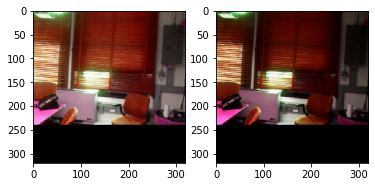

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
#plt.figure('es. predizione decodificata')
#for i in np.random.randint(0, immagini_db_nneigh_pad_augmented_albumented.shape[0], size=10):
for i in range(0,6):
  plt.subplot(121)
  plt.imshow(x_train_augmented[i])
  plt.subplot(122)
  plt.imshow(x_train_augmented_albumented[i])
  plt.show()
  time.sleep(1)

In [26]:
x_train_augmented_albumented.shape

(4860, 320, 320, 3)

# Salvataggio

In [27]:
len(mask_indexes)

4860

In [0]:
np.savez_compressed(PATH_BASE + 'dataset_splitted_nneigh_pad_augm.npz',
                    img_train = x_train_augmented_albumented,
                    map_indexes = mask_indexes,
                    img_val = x_val,
                    img_test = x_test,
                    mask_train = y_train,
                    mask_val = y_val,
                    mask_test = y_test,
                    normali_nneigh_test = normali_nneigh_test)